In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate

In [2]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_moy_2002_v1 = np.genfromtxt('pallcacocha_red_intensity_moy2002_v1.csv', delimiter=",", dtype=float) # nino3 reconstruction
data_moy_2002_v2 = np.genfromtxt('pallcacocha_red_intensity_moy2002_v2.csv', delimiter=",", dtype=float) # nino3 reconstruction

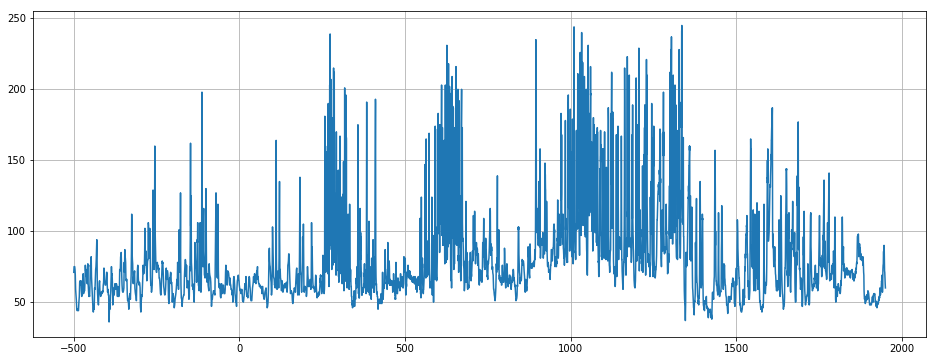

In [3]:
# Since volcanic data is available from -496 in Sigl et al 2015
# the ENSO reconstruction is subset for that period only
yy_moy = 1950-data_moy_2002_v1[:,0]
red_intensity_moy = data_moy_2002_v1[:,1]
idx = yy_moy>-500
yy_moy_sigl = np.flip(yy_moy[idx])
red_intensity_moy_sigl = np.flip(red_intensity_moy[idx])
plt.figure(figsize=(16,6))
plt.plot(yy_moy_sigl, red_intensity_moy_sigl)
plt.grid()

Definition of El Nino in Moy et al 2002 <br />
"On the basis of our assumption that Laguna Pallcacocha is probably recording only the moderate and strong events today (and has been doing so throughout the Holocene), we attribute all the variance between 4- and 15-year periods to El Niño activity."

"Because of these uncertainties, as well as the fact that the lake is recording only the stronger of the events, we take a conservative stance and attribute all variance between 4 and 15 yr to El Niño variability rather than making interpretations within the individual ENSO or decadal bands."

So, we will take the anomaly of annual data of red color intensities and then pass it through a band-pass filter with 4-15 year frequencies and the signal that we get would be used to classify El Nino events. A standard deviation of >+1 in the filtered signal would mean an El Nino

In [4]:
print(yy_moy_sigl.shape[0], yy_moy_sigl, 1950+500+1)

4823 [-499.26 -498.31 -497.41 ... 1948.65 1949.32 1950.  ] 2451


Definitely the data has higher resolution than yearly

In [5]:
yy_moy_ann = np.arange(-499,1950)
red_intensity_moy_ann = np.zeros((yy_moy_ann.shape[0]))

In [6]:
f = interpolate.interp1d(yy_moy_sigl, red_intensity_moy_sigl, kind='linear')
for i in range(yy_moy_ann.shape[0]):
    red_intensity_moy_ann[i] = f(yy_moy_ann[i])

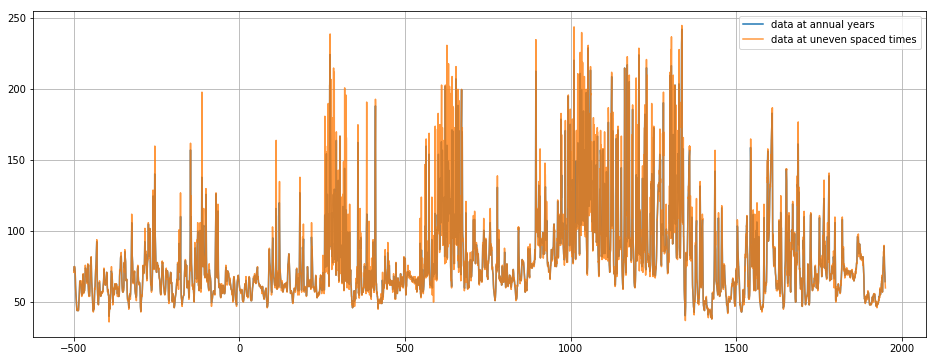

In [7]:
plt.figure(figsize=(16,6))
plt.plot(yy_moy_ann, red_intensity_moy_ann, label='data at annual years')
plt.plot(yy_moy_sigl, red_intensity_moy_sigl, label='data at uneven spaced times', alpha=0.8)
plt.legend()
plt.grid()

In [8]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [9]:
fs = 1 
lowcut = 1/15 # 15 year
highcut = 1/4 # 4 year
red_intensity_moy_ann_filt = butter_bandpass_filter(red_intensity_moy_ann, lowcut, highcut, fs, order=4)
red_intensity_moy_ann_filt_norm = (red_intensity_moy_ann_filt - np.mean(red_intensity_moy_ann_filt))/(np.std(red_intensity_moy_ann_filt))

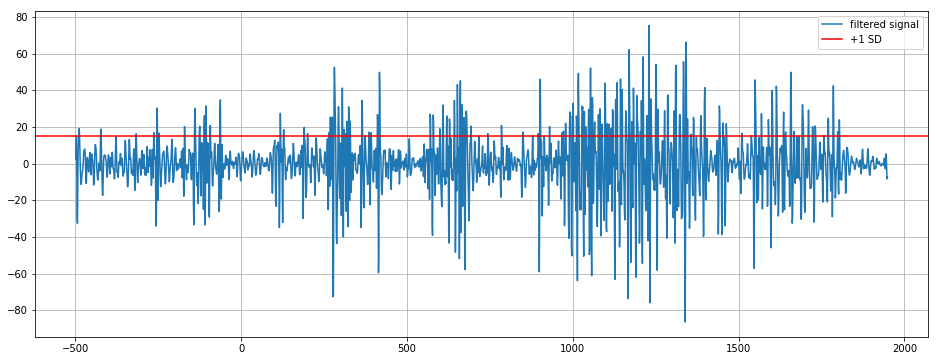

In [10]:
plt.figure(figsize=(16,6))
plt.plot(yy_moy_ann, red_intensity_moy_ann_filt, label='filtered signal')
plt.axhline(y=np.std(red_intensity_moy_ann_filt), color='r', linestyle='-', label='+1 SD')
plt.legend()
plt.grid()

Now the years above +1 SD will be classified as El Nino years

In [11]:
event_en_moy = np.zeros((yy_moy_ann.shape[0]))
event_en_moy[red_intensity_moy_ann_filt>=np.std(red_intensity_moy_ann_filt)] = 1.0

In [12]:
event_yy_volc_all = np.zeros((yy_moy_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_moy_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_moy_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_moy_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_moy_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_moy_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_moy_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_moy_ann.shape[0]))



for i in range(yy_moy_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_moy_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 1.0
    if np.abs(volc[idx[0,0],2])>=5.0:
        event_yy_volc_strong[i] = 1.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [13]:
np.savetxt('el_nino_moy_2002.txt', event_en_moy, delimiter=",")
np.savetxt('all_volc_moy_2002.txt', event_yy_volc_all, delimiter=",")
np.savetxt('strong_volc_moy_2002.txt', event_yy_volc_strong, delimiter=",")
np.savetxt('all_tropical_moy_2002.txt', event_yy_volc_all_trop, delimiter=",")
np.savetxt('strong_tropical_moy_2002.txt', event_yy_volc_strong_trop, delimiter=",")
np.savetxt('all_nh_moy_2002.txt', event_yy_volc_all_nh, delimiter=",")
np.savetxt('strong_nh_moy_2002.txt', event_yy_volc_strong_nh, delimiter=",")
np.savetxt('all_sh_moy_2002.txt', event_yy_volc_all_sh, delimiter=",")
np.savetxt('strong_sh_moy_2002.txt', event_yy_volc_strong_sh, delimiter=",")

In [14]:
event_en_moy_100_ = data_moy_2002_v2[:,1]
yy_moy_ann_100_   = 1950-data_moy_2002_v2[:,0]
idx = yy_moy_ann_100_>-500
event_en_moy_100 = np.flip(event_en_moy_100_[idx])
yy_moy_ann_100 = np.flip(yy_moy_ann_100_[idx])

event_yy_volc_all_100 = np.zeros((event_en_moy_100.shape[0]))
event_yy_volc_strong_100 = np.zeros((event_en_moy_100.shape[0]))
event_yy_volc_all_tropical_100 = np.zeros((event_en_moy_100.shape[0]))
event_yy_volc_strong_tropical_100 = np.zeros((event_en_moy_100.shape[0]))
event_yy_volc_all_nh_100 = np.zeros((event_en_moy_100.shape[0]))
event_yy_volc_strong_nh_100 = np.zeros((event_en_moy_100.shape[0]))
event_yy_volc_all_sh_100 = np.zeros((event_en_moy_100.shape[0]))
event_yy_volc_strong_sh_100 = np.zeros((event_en_moy_100.shape[0]))

In [15]:
for i in range(yy_moy_ann_100.shape[0]):
    #print("loop1 =", yy_moy_ann_100[i])
    win = []
    for j in range(event_yy_volc_all.shape[0]):
        if yy_moy_ann_100[i] - 50 < yy_moy_ann[j] <= yy_moy_ann_100[i] + 50:
            #print(yy_moy_ann[j])
            win.append(event_yy_volc_all[j])
    event_yy_volc_all_100[i] = np.sum(np.asarray(win))
    win = []
    for j in range(event_yy_volc_all.shape[0]):
        if yy_moy_ann_100[i] - 50 < yy_moy_ann[j] <= yy_moy_ann_100[i] + 50:
            if (np.abs(volc[i,2])>=3.7):
                win.append(event_yy_volc_all[j])
    event_yy_volc_strong_100[i] = np.sum(np.asarray(win))

    win = []
    for j in range(event_yy_volc_all.shape[0]):
        if yy_moy_ann_100[i] - 50 < yy_moy_ann[j] <= yy_moy_ann_100[i] + 50:
            if volc[i,1]==1.0:
                win.append(event_yy_volc_all[j])
    event_yy_volc_all_tropical_100[i] = np.sum(np.asarray(win))

    win = []
    for j in range(event_yy_volc_all.shape[0]):
        if yy_moy_ann_100[i] - 50 < yy_moy_ann[j] <= yy_moy_ann_100[i] + 50:
            if (volc[i,1]==1.0) & (np.abs(volc[i,2])>=3.7):
                win.append(event_yy_volc_all[j])
    event_yy_volc_strong_tropical_100[i] = np.sum(np.asarray(win))

    win = []
    for j in range(event_yy_volc_all.shape[0]):
        if yy_moy_ann_100[i] - 50 < yy_moy_ann[j] <= yy_moy_ann_100[i] + 50:
            if volc[i,1]==2.0:
                win.append(event_yy_volc_all[j])
    event_yy_volc_all_nh_100[i] = np.sum(np.asarray(win))

    win = []
    for j in range(event_yy_volc_all.shape[0]):
        if yy_moy_ann_100[i] - 50 < yy_moy_ann[j] <= yy_moy_ann_100[i] + 50:
            if (volc[i,1]==2.0) & (np.abs(volc[i,2])>=3.7):
                win.append(event_yy_volc_all[j])
    event_yy_volc_strong_nh_100[i] = np.sum(np.asarray(win))

    win = []
    for j in range(event_yy_volc_all.shape[0]):
        if yy_moy_ann_100[i] - 50 < yy_moy_ann[j] <= yy_moy_ann_100[i] + 50:
            if volc[i,1]==3.0:
                win.append(event_yy_volc_all[j])
    event_yy_volc_all_sh_100[i] = np.sum(np.asarray(win))

    win = []
    for j in range(event_yy_volc_all.shape[0]):
        if yy_moy_ann_100[i] - 50 < yy_moy_ann[j] <= yy_moy_ann_100[i] + 50:
            if (volc[i,1]==3.0) & (np.abs(volc[i,2])>=3.7):
                win.append(event_yy_volc_all[j])
    event_yy_volc_strong_sh_100[i] = np.sum(np.asarray(win))


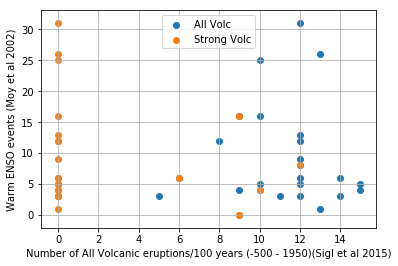

In [16]:
plt.scatter(event_yy_volc_all_100, event_en_moy_100, label='All Volc')
plt.scatter(event_yy_volc_strong_100, event_en_moy_100, label='Strong Volc')
#plt.scatter(event_yy_volc_all_tropical_100, event_en_moy_100, label='All Tropical')
plt.xlabel('Number of All Volcanic eruptions/100 years (-500 - 1950)(Sigl et al 2015)')
plt.ylabel('Warm ENSO events (Moy et al 2002)')
plt.grid()
plt.legend()

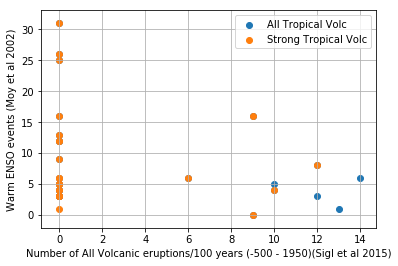

In [17]:
plt.scatter(event_yy_volc_all_tropical_100, event_en_moy_100, label='All Tropical Volc')
plt.scatter(event_yy_volc_strong_tropical_100, event_en_moy_100, label='Strong Tropical Volc')
#plt.scatter(event_yy_volc_all_tropical_100, event_en_moy_100, label='All Tropical')
plt.xlabel('Number of All Volcanic eruptions/100 years (-500 - 1950)(Sigl et al 2015)')
plt.ylabel('Warm ENSO events (Moy et al 2002)')
plt.grid()
plt.legend()

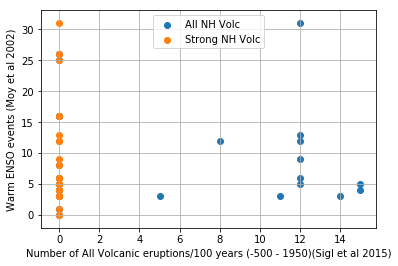

In [18]:
plt.scatter(event_yy_volc_all_nh_100, event_en_moy_100, label='All NH Volc')
plt.scatter(event_yy_volc_strong_nh_100, event_en_moy_100, label='Strong NH Volc')
#plt.scatter(event_yy_volc_all_tropical_100, event_en_moy_100, label='All Tropical')
plt.xlabel('Number of All Volcanic eruptions/100 years (-500 - 1950)(Sigl et al 2015)')
plt.ylabel('Warm ENSO events (Moy et al 2002)')
plt.grid()
plt.legend()

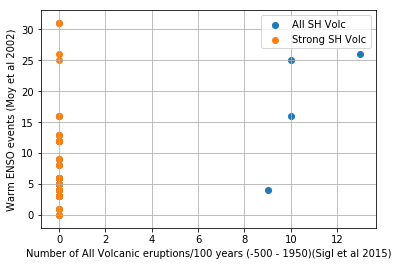

In [19]:
plt.scatter(event_yy_volc_all_sh_100, event_en_moy_100, label='All SH Volc')
plt.scatter(event_yy_volc_strong_sh_100, event_en_moy_100, label='Strong SH Volc')
#plt.scatter(event_yy_volc_all_tropical_100, event_en_moy_100, label='All Tropical')
plt.xlabel('Number of All Volcanic eruptions/100 years (-500 - 1950)(Sigl et al 2015)')
plt.ylabel('Warm ENSO events (Moy et al 2002)')
plt.grid()
plt.legend()

In [20]:
print(np.sum(event_yy_volc_all))
print(np.sum(event_yy_volc_strong))
print(np.sum(event_yy_volc_all_trop))
print(np.sum(event_yy_volc_strong_trop))
print(np.sum(event_yy_volc_all_nh))
print(np.sum(event_yy_volc_strong_nh))
print(np.sum(event_yy_volc_all_sh))
print(np.sum(event_yy_volc_strong_sh))

277.0
48.0
77.0
50.0
139.0
11.0
61.0
1.0


In [21]:
# Bootstrap
N = 1000
win = 5
count_elnino_all_volc = np.zeros((N, win))
count_elnino_strong_volc  = np.zeros((N, win))
count_elnino_all_trop  = np.zeros((N, win))
count_elnino_strong_trop  = np.zeros((N, win))
count_elnino_all_nh  = np.zeros((N, win))
count_elnino_strong_nh  = np.zeros((N, win))
count_elnino_all_sh  = np.zeros((N, win))

In [22]:
idx_all = np.asarray(np.where(event_yy_volc_all == 1.0))
idx_strong = np.asarray(np.where(event_yy_volc_strong == 1.0))
idx_all_trop = np.asarray(np.where(event_yy_volc_all_trop == 1.0))
idx_strong_trop = np.asarray(np.where(event_yy_volc_strong_trop == 1.0))
idx_all_nh = np.asarray(np.where(event_yy_volc_all_nh == 1.0))
idx_strong_nh = np.asarray(np.where(event_yy_volc_strong_nh == 1.0))
idx_all_sh = np.asarray(np.where(event_yy_volc_all_sh == 1.0))

In [23]:
print(idx_all[0])

[   8   12   21   34   65   69   73   81   86   96  103  107  114  123
  137  143  147  153  160  168  170  173  198  200  206  220  244  252
  255  271  282  290  309  319  331  335  338  341  352  358  360  376
  394  399  414  453  455  464  478  491  503  530  557  586  594  601
  613  620  623  642  649  659  663  668  671  691  705  714  717  725
  729  735  743  765  780  798  803  806  809  831  844  852  857  859
  865  868  878  887  892  910  917  922  925  932  951  955  961  966
  968  986  991 1000 1010 1020 1027 1035 1039 1046 1070 1073 1080 1088
 1094 1106 1125 1128 1131 1136 1140 1156 1170 1181 1187 1193 1197 1212
 1216 1224 1231 1244 1248 1249 1255 1263 1276 1281 1299 1316 1318 1321
 1326 1334 1336 1340 1352 1358 1368 1375 1378 1379 1399 1403 1407 1415
 1428 1438 1445 1452 1457 1459 1469 1475 1481 1489 1497 1502 1510 1516
 1519 1527 1538 1556 1563 1566 1591 1607 1614 1617 1626 1636 1670 1679
 1681 1690 1699 1709 1721 1729 1735 1757 1761 1768 1775 1785 1805 1828
 1835 

In [24]:
red_intensity_moy_ann_filt_norm = (red_intensity_moy_ann_filt - np.mean(red_intensity_moy_ann_filt))/(np.std(red_intensity_moy_ann_filt))
niter = 0
while niter<N:
    rand_year_all = random.sample(list(idx_all[0]), 1)
    if (rand_year_all[0]<red_intensity_moy_ann_filt.shape[0]-win):
        count_elnino_all_volc[niter,:] = red_intensity_moy_ann_filt_norm[rand_year_all[0]:rand_year_all[0]+win]
    
    rand_year_strong = random.sample(list(idx_strong[0]), 1)
    if (rand_year_strong[0]<red_intensity_moy_ann_filt.shape[0]-win):
        count_elnino_strong_volc[niter,:] = red_intensity_moy_ann_filt_norm[rand_year_strong[0]:rand_year_strong[0]+win]
    
    rand_year_all_trop = random.sample(list(idx_all_trop[0]), 1)
    if (rand_year_all_trop[0]<red_intensity_moy_ann_filt.shape[0]-win):
        count_elnino_all_trop[niter,:] = red_intensity_moy_ann_filt_norm[rand_year_all_trop[0]:rand_year_all_trop[0]+win]

    rand_year_strong_trop = random.sample(list(idx_strong_trop[0]), 1)
    if (rand_year_strong_trop[0]<red_intensity_moy_ann_filt.shape[0]-win):
        count_elnino_strong_trop[niter,:] = red_intensity_moy_ann_filt_norm[rand_year_strong_trop[0]:rand_year_strong_trop[0]+win]

    rand_year_all_nh = random.sample(list(idx_all_nh[0]), 1)
    if (rand_year_all_nh[0]<red_intensity_moy_ann_filt.shape[0]-win):
        count_elnino_all_nh[niter,:] = red_intensity_moy_ann_filt_norm[rand_year_all_nh[0]:rand_year_all_nh[0]+win]

    rand_year_strong_nh = random.sample(list(idx_strong_nh[0]), 1)
    if (rand_year_strong_nh[0]<red_intensity_moy_ann_filt.shape[0]-win):
        count_elnino_strong_nh[niter,:] = red_intensity_moy_ann_filt_norm[rand_year_strong_nh[0]:rand_year_strong_nh[0]+win]

    rand_year_all_sh = random.sample(list(idx_all_sh[0]), 1)
    if (rand_year_all_sh[0]<red_intensity_moy_ann_filt.shape[0]-win):
        count_elnino_all_sh[niter,:] = red_intensity_moy_ann_filt_norm[rand_year_all_sh[0]:rand_year_all_sh[0]+win]
    
    #print(s[rand_year_all[0]:rand_year_all[0]+win])
    #print(rand_year_all[0])
    niter = niter + 1 

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


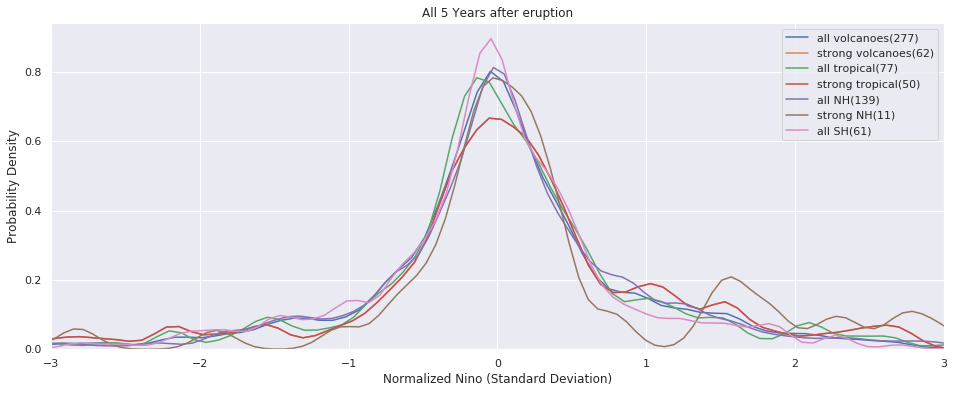

In [25]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc.flatten(), label='all volcanoes(277)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong volcanoes(62)')
sns.kdeplot(count_elnino_all_trop.flatten(), label='all tropical(77)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong tropical(50)')
sns.kdeplot(count_elnino_all_nh.flatten(), label='all NH(139)')
sns.kdeplot(count_elnino_strong_nh.flatten(), label='strong NH(11)')
sns.kdeplot(count_elnino_all_sh.flatten(), label='all SH(61)')
plt.title('All 5 Years after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


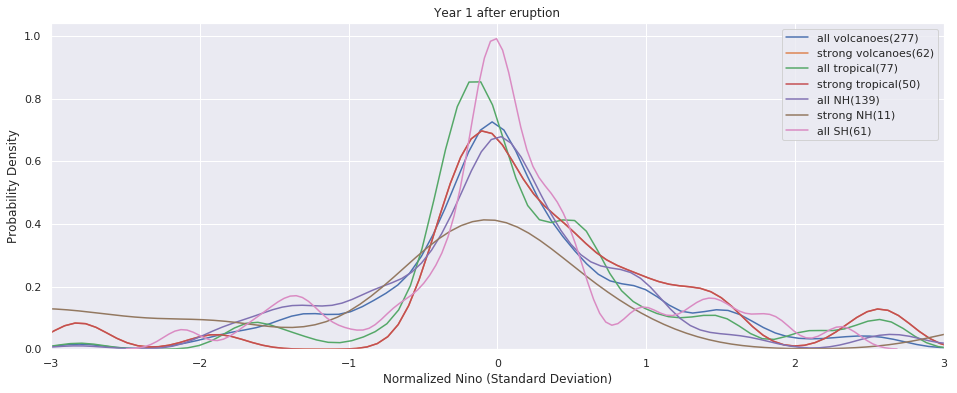

In [26]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,0], label='all volcanoes(277)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong volcanoes(62)')
sns.kdeplot(count_elnino_all_trop[:,0], label='all tropical(77)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong tropical(50)')
sns.kdeplot(count_elnino_all_nh[:,0], label='all NH(139)')
sns.kdeplot(count_elnino_strong_nh[:,0], label='strong NH(11)')
sns.kdeplot(count_elnino_all_sh[:,0], label='all SH(61)')
plt.title('Year 1 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


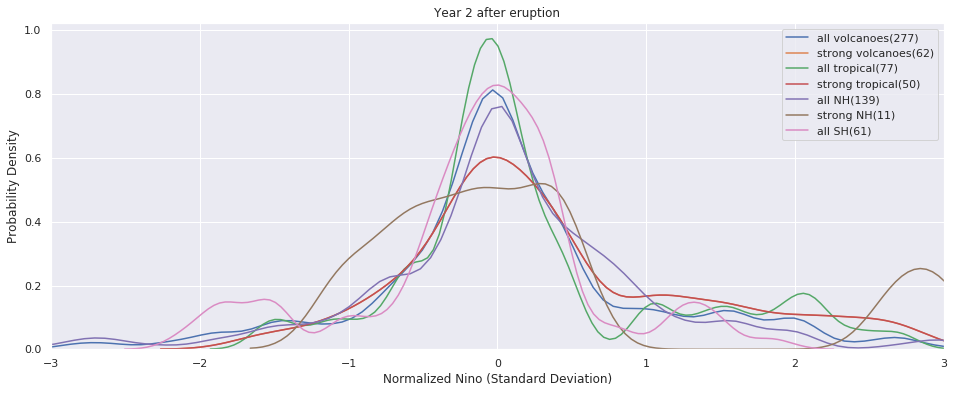

In [27]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,1], label='all volcanoes(277)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong volcanoes(62)')
sns.kdeplot(count_elnino_all_trop[:,1], label='all tropical(77)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong tropical(50)')
sns.kdeplot(count_elnino_all_nh[:,1], label='all NH(139)')
sns.kdeplot(count_elnino_strong_nh[:,1], label='strong NH(11)')
sns.kdeplot(count_elnino_all_sh[:,1], label='all SH(61)')
plt.title('Year 2 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


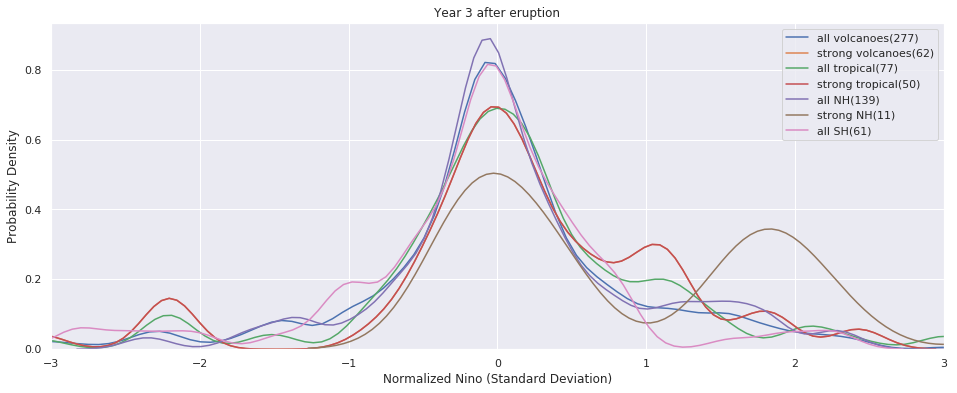

In [28]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,2], label='all volcanoes(277)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong volcanoes(62)')
sns.kdeplot(count_elnino_all_trop[:,2], label='all tropical(77)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong tropical(50)')
sns.kdeplot(count_elnino_all_nh[:,2], label='all NH(139)')
sns.kdeplot(count_elnino_strong_nh[:,2], label='strong NH(11)')
sns.kdeplot(count_elnino_all_sh[:,2], label='all SH(61)')
plt.title('Year 3 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


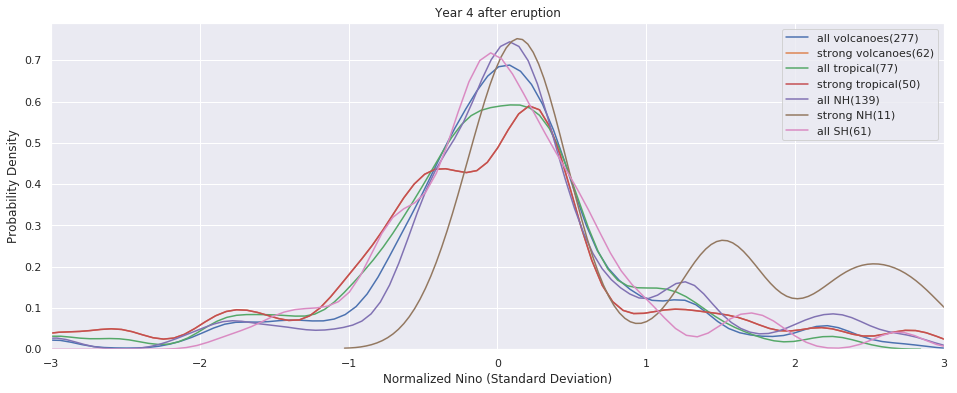

In [29]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,3], label='all volcanoes(277)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong volcanoes(62)')
sns.kdeplot(count_elnino_all_trop[:,3], label='all tropical(77)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong tropical(50)')
sns.kdeplot(count_elnino_all_nh[:,3], label='all NH(139)')
sns.kdeplot(count_elnino_strong_nh[:,3], label='strong NH(11)')
sns.kdeplot(count_elnino_all_sh[:,3], label='all SH(61)')
plt.title('Year 4 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


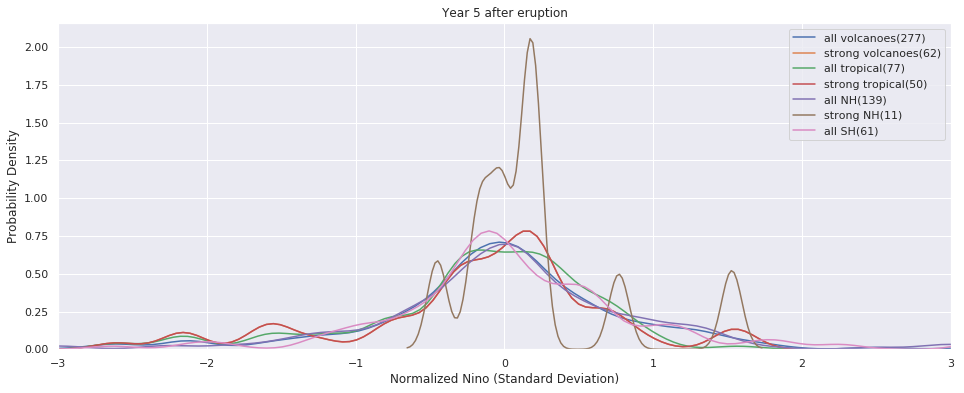

In [30]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,4], label='all volcanoes(277)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong volcanoes(62)')
sns.kdeplot(count_elnino_all_trop[:,4], label='all tropical(77)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong tropical(50)')
sns.kdeplot(count_elnino_all_nh[:,4], label='all NH(139)')
sns.kdeplot(count_elnino_strong_nh[:,4], label='strong NH(11)')
sns.kdeplot(count_elnino_all_sh[:,4], label='all SH(61)')
plt.title('Year 5 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

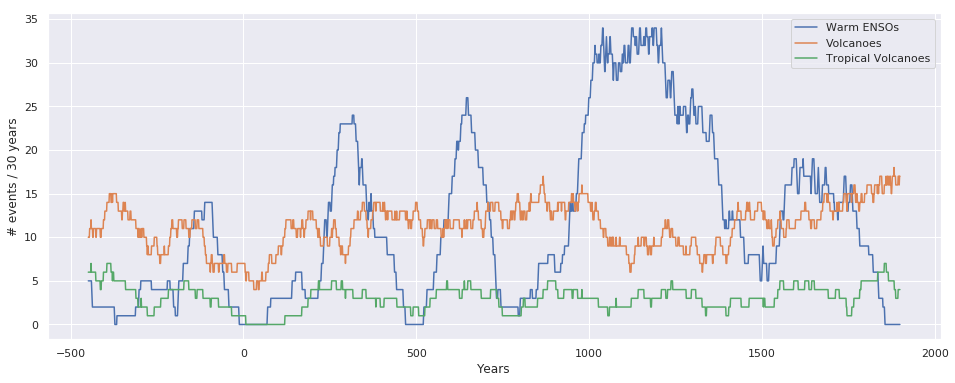

In [31]:
window = 100
event_en_moy_mov = np.zeros((event_en_moy.shape[0]-window))
event_yy_volc_all_mov = np.zeros((event_yy_volc_all.shape[0]-window))
event_yy_volc_strong_mov = np.zeros((event_yy_volc_strong.shape[0]-window))
event_yy_volc_all_trop_mov = np.zeros((event_yy_volc_all_trop.shape[0]-window))
event_yy_volc_strong_trop_mov = np.zeros((event_yy_volc_strong_trop.shape[0]-window))
event_yy_volc_all_nh_mov = np.zeros((event_yy_volc_all_nh.shape[0]-window))
event_yy_volc_strong_nh_mov = np.zeros((event_yy_volc_strong_nh.shape[0]-window))
event_yy_volc_all_sh_mov = np.zeros((event_yy_volc_all_sh.shape[0]-window))
event_yy_volc_strong_sh_mov = np.zeros((event_yy_volc_strong_sh.shape[0]-window))



for i in range(event_en_moy.shape[0]-window):
    event_en_moy_mov[i] = np.sum(event_en_moy[i:i+window])
    event_yy_volc_all_mov[i] = np.sum(event_yy_volc_all[i:i+window])
    event_yy_volc_strong_mov[i] = np.sum(event_yy_volc_strong[i:i+window])
    event_yy_volc_all_trop_mov[i] = np.sum(event_yy_volc_all_trop[i:i+window])
    event_yy_volc_strong_trop_mov[i] = np.sum(event_yy_volc_strong_trop[i:i+window])
    event_yy_volc_all_nh_mov[i] = np.sum(event_yy_volc_all_nh[i:i+window])
    event_yy_volc_strong_nh_mov[i] = np.sum(event_yy_volc_strong_nh[i:i+window])
    event_yy_volc_all_sh_mov[i] = np.sum(event_yy_volc_all_sh[i:i+window])
    event_yy_volc_strong_sh_mov[i] = np.sum(event_yy_volc_strong_sh[i:i+window])
    
    

plt.figure(figsize=(16,6))
plt.plot(yy_moy_ann[int(window/2):event_en_moy.shape[0]-int(window/2)], event_en_moy_mov, label='Warm ENSOs')
plt.plot(yy_moy_ann[int(window/2):event_en_moy.shape[0]-int(window/2)], event_yy_volc_all_mov, label='Volcanoes')
plt.plot(yy_moy_ann[int(window/2):event_en_moy.shape[0]-int(window/2)], event_yy_volc_all_trop_mov, label='Tropical Volcanoes')
plt.xlabel('Years')
plt.ylabel('# events / 30 years')
plt.legend()

In [32]:
from scipy.stats.stats import pearsonr
print(pearsonr(event_en_moy_mov,event_yy_volc_all_mov))
print(pearsonr(event_en_moy_mov,event_yy_volc_strong_mov))
print(pearsonr(event_en_moy_mov,event_yy_volc_all_trop_mov))
print(pearsonr(event_en_moy_mov,event_yy_volc_strong_trop_mov))
print(pearsonr(event_en_moy_mov,event_yy_volc_all_nh_mov))
print(pearsonr(event_en_moy_mov,event_yy_volc_strong_nh_mov))
print(pearsonr(event_en_moy_mov,event_yy_volc_all_sh_mov))
print(pearsonr(event_en_moy_mov,event_yy_volc_strong_sh_mov))


(-0.1569531164770316, 2.0039132286219926e-14)
(0.12594915718302913, 9.041621190690311e-10)
(0.14438102797441385, 2.053771803816329e-12)
(0.22906304189415289, 2.428402512677554e-29)
(-0.1489629776463115, 3.975616081553984e-13)
(0.10023999816179897, 1.127566476582445e-06)
(-0.15894781908927283, 9.272754059282863e-15)
(-0.20961192338115767, 9.820276135459938e-25)


In [33]:
# Distribution of count of Warm ENSO events after volcanic eruptions and otherwise box whisker plot as well as distribution

In [34]:
# Bootstrap
N = 1000
win = 20
count_elnino_all_volc = np.zeros((N))
count_elnino_strong_volc  = np.zeros((N))
count_elnino_all_trop  = np.zeros((N))
count_elnino_strong_trop  = np.zeros((N))
count_elnino_all_nh  = np.zeros((N))
count_elnino_strong_nh  = np.zeros((N))
count_elnino_all_sh  = np.zeros((N))

In [35]:
niter = 0
while niter<N:
    rand_year_all = random.sample(list(idx_all[0]), 1)
    if (rand_year_all[0]<event_en_moy.shape[0]-win):
        count_elnino_all_volc[niter] = np.sum(event_en_moy[rand_year_all[0]:rand_year_all[0]+win])
    
    rand_year_strong = random.sample(list(idx_strong[0]), 1)
    if (rand_year_strong[0]<event_en_moy.shape[0]-win):
        count_elnino_strong_volc[niter] = np.sum(event_en_moy[rand_year_strong[0]:rand_year_strong[0]+win])
    
    rand_year_all_trop = random.sample(list(idx_all_trop[0]), 1)
    if (rand_year_all_trop[0]<event_en_moy.shape[0]-win):
        count_elnino_all_trop[niter] = np.sum(event_en_moy[rand_year_all_trop[0]:rand_year_all_trop[0]+win])

    rand_year_strong_trop = random.sample(list(idx_strong_trop[0]), 1)
    if (rand_year_strong_trop[0]<event_en_moy.shape[0]-win):
        count_elnino_strong_trop[niter] = np.sum(event_en_moy[rand_year_strong_trop[0]:rand_year_strong_trop[0]+win])

    rand_year_all_nh = random.sample(list(idx_all_nh[0]), 1)
    if (rand_year_all_nh[0]<event_en_moy.shape[0]-win):
        count_elnino_all_nh[niter] = np.sum(event_en_moy[rand_year_all_nh[0]:rand_year_all_nh[0]+win])

    rand_year_strong_nh = random.sample(list(idx_strong_nh[0]), 1)
    if (rand_year_strong_nh[0]<event_en_moy.shape[0]-win):
        count_elnino_strong_nh[niter] = np.sum(event_en_moy[rand_year_strong_nh[0]:rand_year_strong_nh[0]+win])

    rand_year_all_sh = random.sample(list(idx_all_sh[0]), 1)
    if (rand_year_all_sh[0]<event_en_moy.shape[0]-win):
        count_elnino_all_sh[niter] = np.sum(event_en_moy[rand_year_all_sh[0]:rand_year_all_sh[0]+win])
    
    #print(s[rand_year_all[0]:rand_year_all[0]+win])
    #print(rand_year_all[0])
    niter = niter + 1 

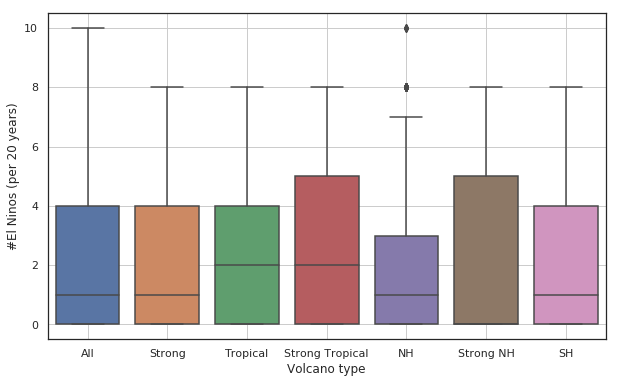

In [36]:
# ENSO has a 2-7 year cycle so El Nino can come every 4-5 years, hence 2 El Ninos per 10 years 
import pandas as pd 
import seaborn as sns
data1 = pd.DataFrame({ 'Volcano type' : np.repeat('All',N), '#El Ninos (per 20 years)': count_elnino_all_volc })
data2 = pd.DataFrame({ 'Volcano type' : np.repeat('Strong',N), '#El Ninos (per 20 years)': count_elnino_strong_volc })
data3 = pd.DataFrame({ 'Volcano type' : np.repeat('Tropical',N), '#El Ninos (per 20 years)': count_elnino_all_trop })
data4 = pd.DataFrame({ 'Volcano type' : np.repeat('Strong Tropical',N), '#El Ninos (per 20 years)': count_elnino_strong_trop })
data5 = pd.DataFrame({ 'Volcano type' : np.repeat('NH',N), '#El Ninos (per 20 years)': count_elnino_all_nh })
data6 = pd.DataFrame({ 'Volcano type' : np.repeat('Strong NH',N), '#El Ninos (per 20 years)': count_elnino_strong_nh })
data7 = pd.DataFrame({ 'Volcano type' : np.repeat('SH',N), '#El Ninos (per 20 years)': count_elnino_all_sh })
#data8 = pd.DataFrame({ 'Volcano type' : np.repeat('Strong SH',N), 'Count (per 10 years)': count_elnino_strong_sh })


df=data1.append(data2).append(data3).append(data4).append(data5).append(data6).append(data7)
plt.figure(figsize=(10,6))
sns.set_style(style='white')
sns.boxplot(x='Volcano type', y='#El Ninos (per 20 years)', data=df)
plt.grid()

In [37]:
nino3_moy_2002_anom_yy = np.zeros((red_intensity_moy_ann_filt_norm.shape[0],3))
nino3_moy_2002_anom_yy[:,0] = yy_moy_ann[:]
nino3_moy_2002_anom_yy[:,1] = event_yy_volc_strong[:]
nino3_moy_2002_anom_yy[:,2] = red_intensity_moy_ann_filt_norm[:]
np.savetxt('nino3_moy_2002_anom_yy.txt', nino3_moy_2002_anom_yy, delimiter=",")